In [1]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import sys 

sys.path.insert(0,'..')
import jabble.dataset
import jabble.loss
import jabble.model

import pickle
import os

sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset

In [2]:
indir = '/scratch/mdd423/simulacra/out/2021-11-16-2/'
outdir = '/scratch/mdd423/wobble_jax/out/2021-11-16/'

init_strings = ['eprv','bc','midway']
modelnames = {x: sorted([os.path.join(outdir, file) for file in os.listdir(outdir) if file.startswith('expres_e30') and ('gs{}_f256_f256_f512'.format(x) in file)]) for x in init_strings}

datanames = sorted([os.path.join(indir, file) for file in os.listdir(indir) if file.startswith('expres_e30')])
    

In [3]:
for x,y in zip(modelnames['eprv'], datanames):
#     filenames.append(x)
#     datanames.append(y)
    
    print(x)
    print(y)
    print('\n')

/scratch/mdd423/wobble_jax/out/2021-11-16/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr1.6e+04gseprv_f256_f256_f512.jab
/scratch/mdd423/simulacra/out/2021-11-16-2/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr1.6e+04.h5


/scratch/mdd423/wobble_jax/out/2021-11-16/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr1.6e+05gseprv_f256_f256_f512.jab
/scratch/mdd423/simulacra/out/2021-11-16-2/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr1.6e+05.h5


/scratch/mdd423/wobble_jax/out/2021-11-16/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr3.1e+03gseprv_f256_f256_f512.jab
/scratch/mdd423/simulacra/out/2021-11-16-2/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr3.1e+03.h5


/scratch/mdd423/wobble_jax/out/2021-11-16/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr3.9e+03gseprv_f256_f256_f512.jab
/scratch/mdd423/simulacra/out/2021-11-16-2/expres_e30_R130000.0_a4000.0_p67.3_l7.0e+039.5e+03_snr3.9e+03.h5


/scratch/mdd423/wobble_jax/out/2021-11-16/ex

In [4]:
models = {}
for key in (init_strings):
    models[key] = []
    for name in modelnames[key]:
        models[key].append(jabble.model.load(name))

In [5]:
import matplotlib.pyplot as plt

In [6]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low

In [7]:
datasets = []
all_data = []

for filename in datanames:
    data    = simulacra.dataset.from_h5(filename)
    epoches = data['data']['flux'].shape[0]

    masks = np.array(data['data']['mask'],dtype=bool)
    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])
    
    masks = np.array(data['data']['mask'],dtype=bool)
    masks = np.logical_or(np.isnan(ferr), masks)
    masks = np.logical_or(np.isnan(flux), masks)
    masks = np.logical_or(flux <= 0, masks)
    
    sigma = 80
    wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks,normalize,nargs=[sigma])
    wob_data.mask = np.logical_or(np.isnan(wob_data.ys),wob_data.mask)
    wob_data.set_masks(0.0,10.0)
    
    datasets.append(wob_data)
    all_data.append(data)

<HDF5 dataset "obs_times": shape (30,), type "|O">
<HDF5 dataset "obs_times": shape (30,), type "|O">
<HDF5 dataset "obs_times": shape (30,), type "|O">
<HDF5 dataset "obs_times": shape (30,), type "|O">
<HDF5 dataset "obs_times": shape (30,), type "|O">
<HDF5 dataset "obs_times": shape (30,), type "|O">
<HDF5 dataset "obs_times": shape (30,), type "|O">
<HDF5 dataset "obs_times": shape (30,), type "|O">


In [8]:
obs_times = all_data[0]['data']['obs_times']
exp_times = all_data[0]['data']['exp_times']
times     = (at.Time(obs_times + exp_times/2))

loc    = all_data[0]['parameters']['detector']['loc']
target = all_data[0]['parameters']['star']['target']
resolution = float(all_data[0]['parameters']['detector']['_resolution'][()])

# distances.append(data['parameters']['star']['distance'])
period  = all_data[0]['parameters']['star']['period']
bcs = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
# rvs.append(data['data']['rvs'].to(u.km/u.s))
# snrs.append(np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])]))

In [9]:
resolution

130000.0

In [10]:
print(all_data[0]['parameters']['star']['distance'])

50.0 pc


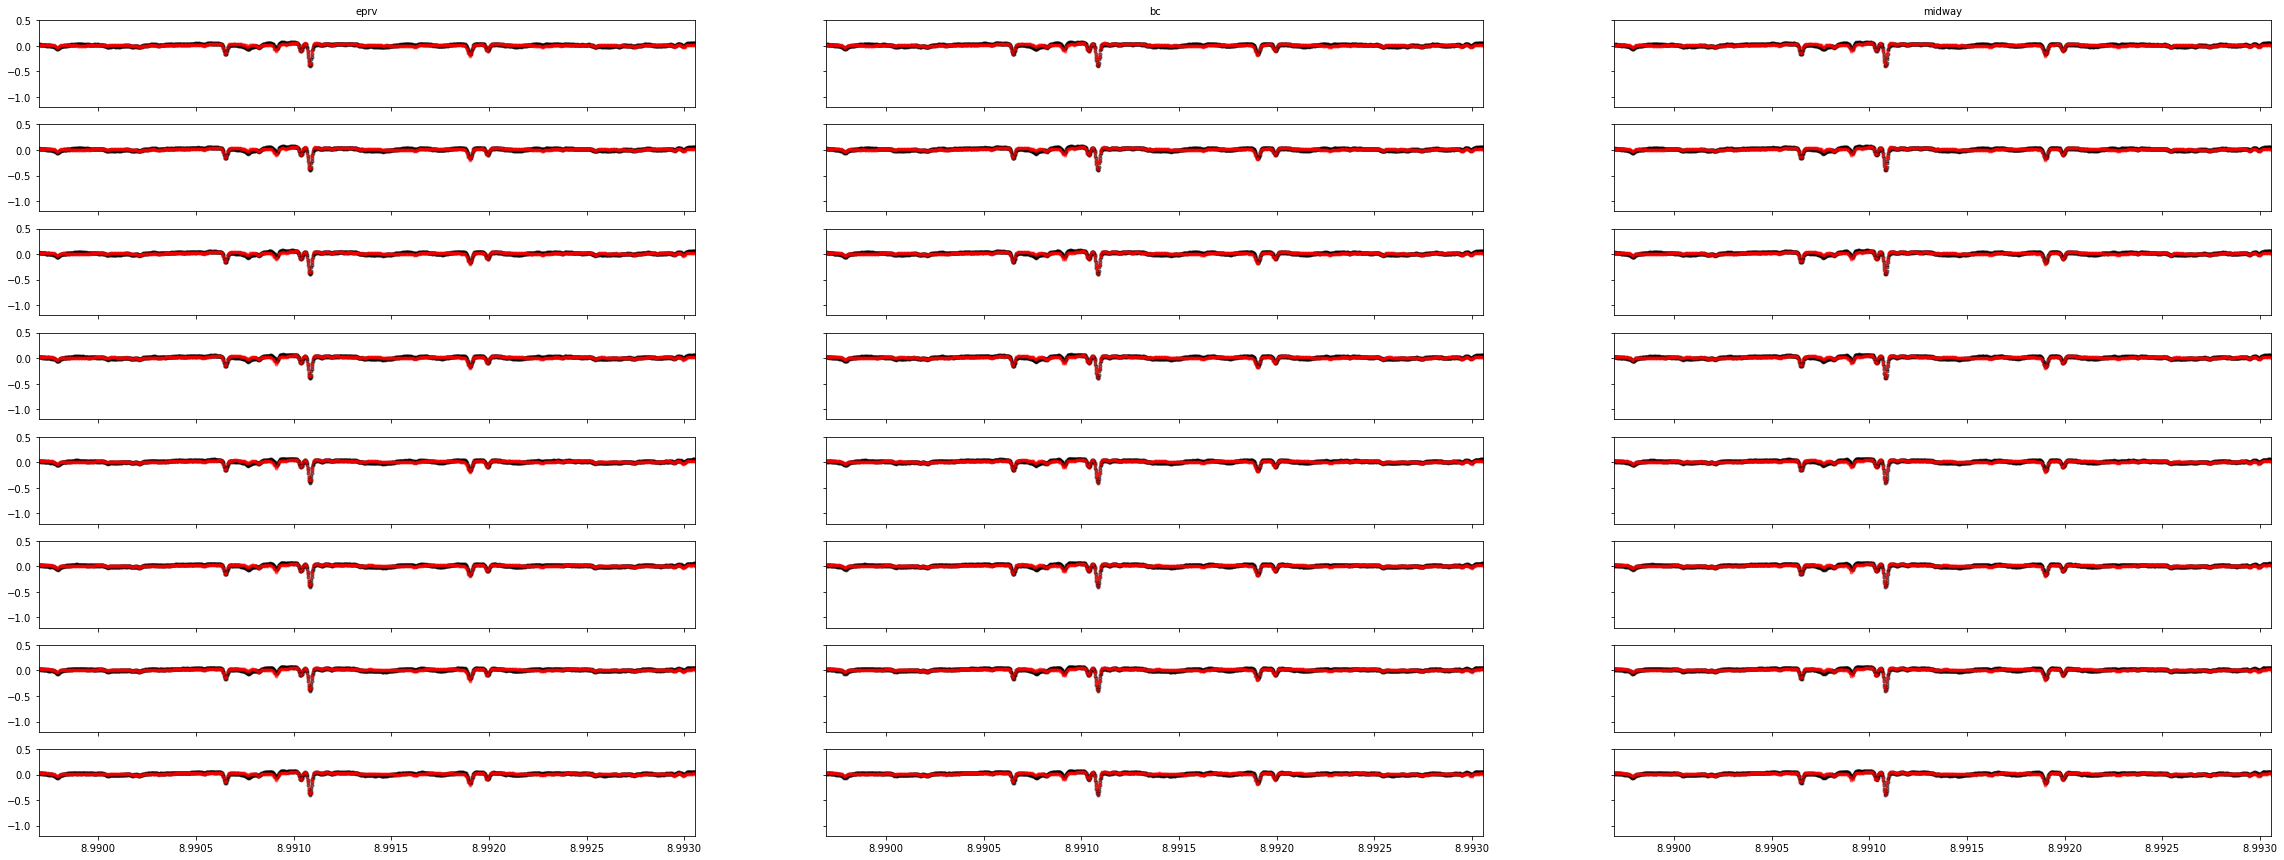

In [11]:
sigma = 80
xpmin = np.log(8020)
xpmax = np.log(8047)
plt_unit = u.Angstrom
plt_epoch = 1
fig, axes = plt.subplots(len(datasets),len(init_strings),figsize=(5 * len(datasets),5 * len(init_strings)),sharex=True,sharey=True,facecolor=(1, 1, 1))

for ax, col in zip(axes[0], init_strings):
    ax.set_title(col, fontdict = {'fontsize' : 10})

for i in range(len(datasets)):
    for j,key in enumerate(init_strings):
        
        axes[i,j].errorbar(datasets[i].xs[plt_epoch,:],datasets[i].ys[plt_epoch,:],datasets[i].yerr[plt_epoch,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
        axes[i,j].plot(models[key][i][1].xs-models[key][i][0].p[plt_epoch],models[key][i][1].p,'.r',linestyle='solid',linewidth=2.2,zorder=2,alpha=0.5,ms=6)
        axes[i,j].set_xlim(xpmin,xpmax)
        axes[i,j].set_ylim(-1.2,0.5)
plt.savefig('../out/star_plots_e{}_x{}-{}.png'.format(plt_epoch,xpmin,xpmax),dpi=100,bbox_inches='tight')
plt.show()

In [12]:
# print(snrs)
from matplotlib import cm

In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline

In [15]:
rvs = all_data[0]['data']['rvs'].to(u.km/u.s)
for i in range(len(all_data)):
    print(np.where(~(rvs == all_data[i]['data']['rvs'].to(u.km/u.s))))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [16]:
init_dict = {'eprv': rvs,'bc':bcs,'midway':(rvs + bcs)/2}

[ 50.   5. 250. 200.  20. 150. 100.  10.]
eprv 0: 2
eprv 1: 2
eprv 2: 2
eprv 3: 2
eprv 4: 2
eprv 5: 2
eprv 6: 2
eprv 7: 2
bc 1: 2
bc 2: 2
bc 5: 2
bc 6: 2
midway 0: 2
midway 2: 2
midway 3: 2
midway 5: 2
midway 6: 2


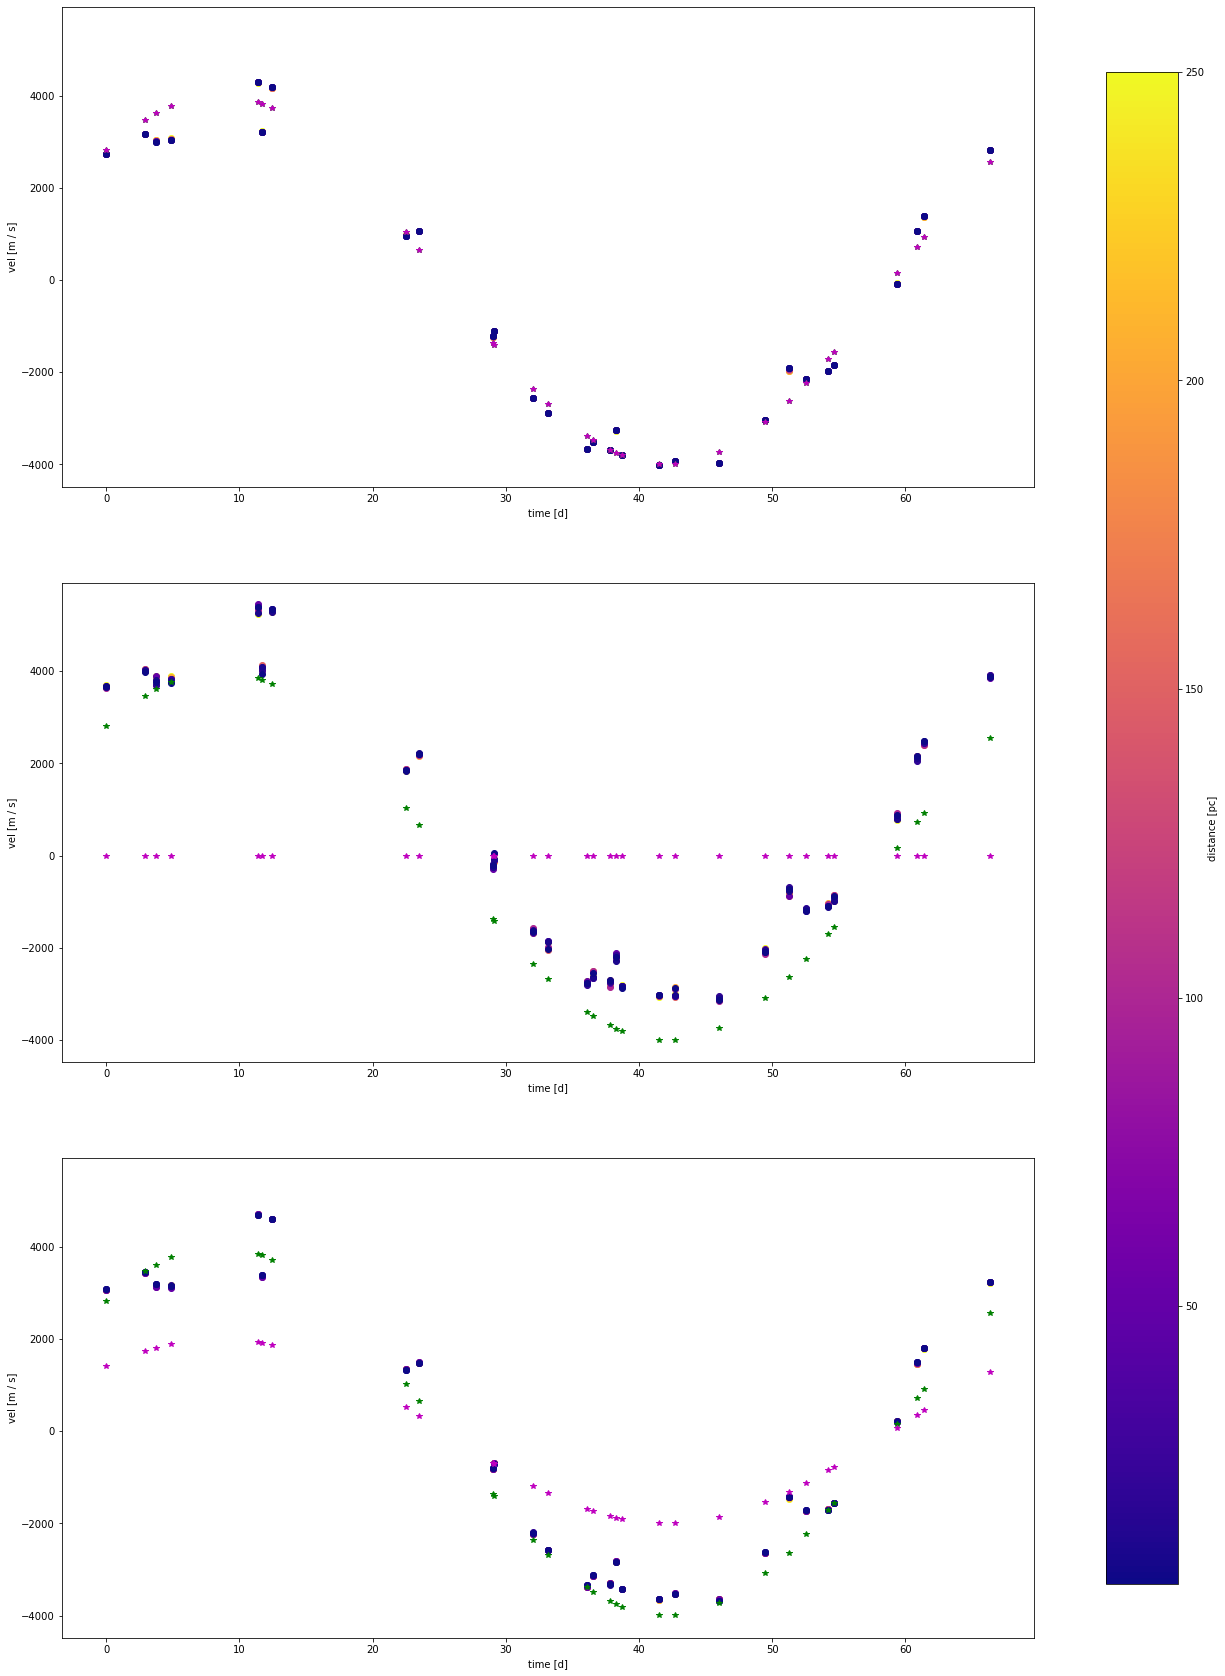

In [37]:
fig, axes = plt.subplots(len(init_strings),sharey=True,figsize=(20,30),facecolor=(1, 1, 1))
v_unit = u.m/u.s

# pc_dist = -np.log(np.array([np.mean(x['data']['snr_readout'][~np.isnan(x['data']['snr_readout'])]) for x in all_data]))
pc_dist = np.array([x['parameters']['star']['distance'].to(u.pc).value for x in all_data] )

print(pc_dist)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)

cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=np.min(pc_dist),vmax=np.max(pc_dist))
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cbar_ax) # ticks=pc_dist ,boundaries=np.arange(np.min(pc_dist),np.max(pc_dist))
cbar.set_label('distance [pc]')

for j,key in enumerate(init_strings):
    
    axes[j].plot((times - min(times)).to(u.day).value % period.value,(rvs-bcs).to(v_unit).value,'*g',label='truth')
    axes[j].plot((times - min(times)).to(u.day).value % period.value,(init_dict[key]-bcs).to(v_unit).value,'*m',label='truth')
    
    # v_unit = u.km/u.s
    # axes[1].plot((timess[0] - min(timess[0])).to(u.day).value,(rvs[0]).to(v_unit).value,'og',label='truth')

    

    # fig.colorbar(cm.plasma)
    for i in range(len(datasets)):
        for rs,x in enumerate(models[key][i].results):
            if 'ABNORMAL' in x.message:
                print('{} {}: {}'.format(key,i,rs))
#                 axes[j].plot((times - min(times)).to(u.day).value % period.value,(final_vels-bcs).to(v_unit).value,'cs',zorder=1000000)
#                 print(x.nit,x.message) 
        final_vels = jabble.dataset.velocityfromshift(models[key][i][0].p)
        plt_vels = final_vels - bcs
        plt_vels += -np.mean(plt_vels)

        v_unit = u.m/u.s
        plot1 = axes[j].plot((times - min(times)).to(u.day).value % period.value,(final_vels-bcs).to(v_unit).value,'o',label='distances {:2.1f}'.format(pc_dist[i]),zorder=1/pc_dist[i],color=cmap(norm(pc_dist[i])))
        axes[j].set_ylabel('vel [{}]'.format(v_unit))
        axes[j].set_xlabel('time [d]')

   
plt.savefig('../out/velocity_plots2.png',dpi=300,bbox_inches='tight')
plt.show()

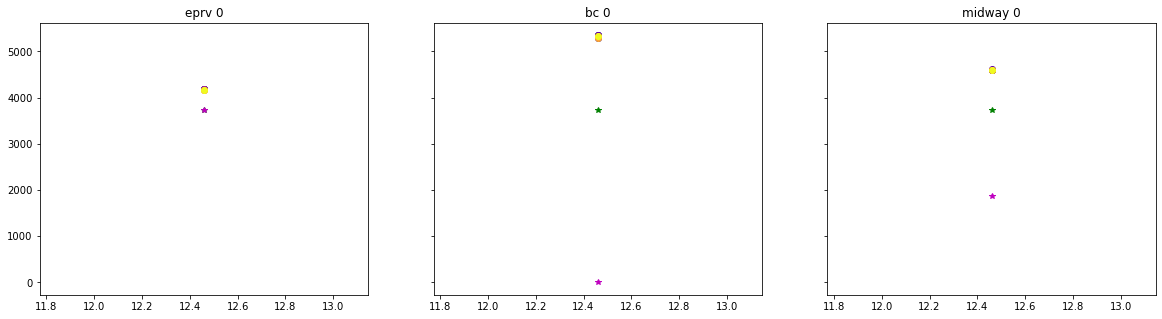

In [18]:
fig, axes = plt.subplots(1,len(init_strings),sharey=True,figsize=(20,5),facecolor=(1, 1, 1))
v_unit = u.m/u.s

# pc_dist = -np.log(np.array([np.mean(x['data']['snr_readout'][~np.isnan(x['data']['snr_readout'])]) for x in all_data]))
pc_dist = np.array([x['parameters']['star']['distance'].to(u.pc).value for x in all_data] )

# print(pc_dist)

# tmin, tmax = 50, 52
ptime = (times - min(times)).to(u.day).value % period.value
# mask  = np.multiply((ptime > tmin), (ptime < tmax))

mask = 0
# mask  = np.ones(mask.shape,dtype=bool)
for j,key in enumerate(init_strings):
    
#     axes[j].figure(figsize=(20,10))
    axes[j].plot(ptime[mask],(rvs-bcs).to(v_unit).value[mask],'*g',label='truth')
    axes[j].plot(ptime[mask],(init_dict[key]-bcs).to(v_unit).value[mask],'*m',label='truth')
    axes[j].set_title(key + ' {}'.format(mask))


    for i in range(len(datasets)):
        
        final_vels = jabble.dataset.velocityfromshift(models[key][i][0].p)
        axes[j].plot(ptime[mask],(final_vels-bcs).to(v_unit).value[mask],'o',label='distances {:2.1f}'.format(pc_dist[i]),zorder=pc_dist[i],color=cmap(norm(pc_dist[i])))
plt.savefig('../out/velocity_plot_e{}.png'.format(np.where(mask)[0]))
plt.show()


In [19]:
print(ptime)

[12.45903024 60.87159506 32.03655519 66.34360928 51.23739169 22.47949346
 59.35397685 33.1317523  11.37351256 49.49293263 37.81280249 29.13288984
 42.72386623 36.56633248 41.49704039 46.03506584 38.72325631 54.2208037
 54.64969709  2.87837194 61.42478836 36.10136213 23.51417784  3.71633648
 52.56138606 11.69660582 29.02412571 38.29047813  0.          4.84361289]


In [20]:
# for j,key in enumerate(init_strings):
#     for plt_epoch in range(epoches):

#         if mask[plt_epoch]:
#             sigma = 80
#             xpmin = np.log(7110)
#             xpmax = np.log(7115)
#             plt_unit = u.Angstrom
#             fig, axes = plt.subplots(len(datasets),figsize=(5,2 * len(datasets)),sharex=True,sharey=True,facecolor=(1, 1, 1))

#             axes[0].set_title(key + ' {}'.format(plt_epoch), fontdict = {'fontsize' : 10})

#             for i in range(len(datasets)):
#                 axes[i].errorbar(datasets[i].xs[plt_epoch,:],datasets[i].ys[plt_epoch,:],datasets[i].yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=6)
#                 axes[i].plot(models[key][i][1].xs-models[key][i][0].p[plt_epoch],models[key][i][1].p,'.r',linestyle='solid',linewidth=1.2,zorder=2,alpha=0.5,ms=6)
#                 axes[i].set_xlim(xpmin,xpmax)
#                 axes[i].set_ylim(-1.2,0.5)
#             plt.savefig('../out/star_plots__k{}_e{}_x{:2.1e}-{:2.1e}.png'.format(key,plt_epoch,xpmin,xpmax),dpi=100,bbox_inches='tight')
#             plt.show()

In [21]:
import astropy.constants as const
print(jabble.dataset.shifts(const.c/resolution))
print(jabble.model.spacing_from_res(resolution))
print(jabble.model.spacing_from_res(resolution)/2)

7.692307692389783e-06
7.692278106728071e-06
3.846139053364036e-06


In [22]:
diff_x = np.mean(datasets[0].xs[0,1:]- datasets[0].xs[0,:-1])

In [23]:
print(diff_x)

1.9230750734067215e-06


In [24]:
print(jabble.dataset.shifts(1500*u.m/u.s) / diff_x)
print(jabble.dataset.shifts(rvs)/jabble.dataset.shifts(const.c/resolution))

2.6018024450749793
[ -6.96538181 -10.19850276   8.90919658  -7.45445762 -11.71436605
  -0.90529509   8.40059681   9.46966909  -4.35558768   4.69767729
   5.86854662  -2.94729269   5.13902147   6.32205414   5.46593407
   9.08109907   5.77444991   8.27092913   8.6805146    8.60955356
 -10.77642134   8.71209774  -7.69503351  12.17792684   4.54915076
  11.84711938   2.15792128  -5.7643089   -5.02185489  12.08405953]


In [25]:
print(jabble.dataset.velocityfromshift(diff_x))

576.5234031868436 m / s


In [26]:
loss = jabble.loss.ChiSquare()

In [27]:
# epoch_idx = 22
# v_unit = u.km/u.s

# vel_kern = np.arange(-4,4) * u.km/u.s
# for key in init_strings:
#     for i,data in enumerate(datasets):
#         models[key][i].fix()
#         evaluation = loss([],data,epoch_idx,models[key][i])
#         models[key][i].fit(0)
#         loss_grid = np.empty(vel_kern.shape)
#         for j,vel_ele in enumerate(vel_kern):
# #             print(jabble.dataset.shifts(rvs + vel_kern[j]).shape)
#             loss_grid[j] = loss(jabble.dataset.shifts(rvs + vel_kern[j]),data,epoch_idx,models[key][i])
       
#         plt.figure(figsize=(20,8),facecolor=(1, 1, 1))
#         plt.title('snr {} {} e{}'.format(key,np.mean(all_data[i]['data']['snr_readout'][~np.isnan(all_data[i]['data']['snr_readout'])]),epoch_idx))
#         plt.plot((rvs[epoch_idx] + vel_kern).to(v_unit).value, loss_grid,'*r')
#         plt.vlines(rvs[epoch_idx].to(v_unit).value,min(loss_grid),max(loss_grid),'g',label='truth')
#         plt.vlines(jabble.dataset.velocityfromshift(models[key][i][0].p[epoch_idx]).to(v_unit).value,min(loss_grid),max(loss_grid),'m',label='prediction')
#         plt.legend()
#         plt.xlabel('velocity [{}]'.format(v_unit))
#         plt.savefig('../out/lgrid_snr_{}_{:2.1e}_e{}.png'.format(key,np.mean(all_data[i]['data']['snr_readout'][~np.isnan(all_data[i]['data']['snr_readout'])]),epoch_idx))
# #         plt.show()
#         print('final eval: {}\ntruth: {}'.format(evaluation,truth))

In [28]:
sigma = 80*np.mean(models[key][0][1].xs[1:] - models[key][0][1].xs[:-1]) / np.mean(np.log(all_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value)[1:] - np.log(all_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value)[:-1])
print(sigma)

2670.7182268547294


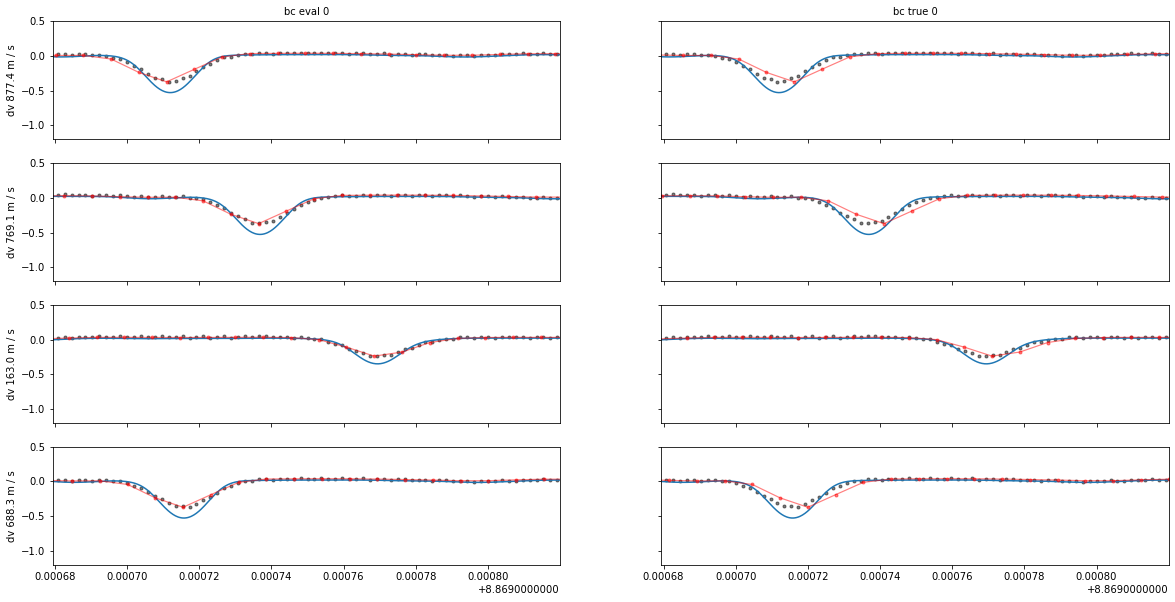

In [45]:
# for j,key in enumerate(init_strings):
key = 'bc'
plt_epoch = 0

max_epoch = 4

xpmin = np.log(7113)
xpmax = np.log(7114)
plt_unit = u.Angstrom
fig, axes = plt.subplots(max_epoch,2,figsize=(20,2.5 * max_epoch ),sharex=True,sharey=True,facecolor=(1, 1, 1))
axes[0,0].set_title(key + ' eval {}'.format(plt_epoch), fontdict = {'fontsize' : 10})
axes[0,1].set_title(key + ' true {}'.format(plt_epoch), fontdict = {'fontsize' : 10})
    
dataset_index = 3

for plt_epoch in range(max_epoch):
    
#     all_data[i].plot_star(axes[i,0],plt_epoch,'xy',normalize,nargs=[sigma])
    axes[plt_epoch,0].plot(np.log(all_data[dataset_index]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normalize(all_data[dataset_index]['theory']['interpolated']['star']['flux'][plt_epoch,:],sigma)))
    axes[plt_epoch,1].plot(np.log(all_data[dataset_index]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normalize(all_data[dataset_index]['theory']['interpolated']['star']['flux'][plt_epoch,:],sigma)))


    plt.setp(axes[plt_epoch, 0], ylabel='dv {:2.1f}'.format(final_vels[plt_epoch] - rvs[plt_epoch]))
    axes[plt_epoch,0].errorbar(datasets[dataset_index].xs[plt_epoch,:],datasets[i].ys[plt_epoch,:],datasets[dataset_index].yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=6)
    axes[plt_epoch,0].plot(models[key][dataset_index][1].xs-models[key][dataset_index][0].p[plt_epoch],models[key][dataset_index][1].p,'.r',linestyle='solid',linewidth=1.2,zorder=2,alpha=0.5,ms=6)
    axes[plt_epoch,0].set_xlim(xpmin,xpmax)
    axes[plt_epoch,0].set_ylim(-1.2,0.5)


    axes[plt_epoch,1].errorbar(datasets[dataset_index].xs[plt_epoch,:],datasets[dataset_index].ys[plt_epoch,:]\
                               ,datasets[dataset_index].yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=6)
    axes[plt_epoch,1].plot(models[key][dataset_index][1].xs-jabble.dataset.shifts(rvs[plt_epoch]),\
                           models[key][dataset_index][1].p,'.r',linestyle='solid',linewidth=1.2,zorder=2,alpha=0.5,ms=6)
    axes[plt_epoch,1].set_xlim(xpmin,xpmax)
    axes[plt_epoch,1].set_ylim(-1.2,0.5)
# plt.savefig('../out/star_plots__k{}_e{}_x{:2.1e}-{:2.1e}.png'.format(key,plt_epoch,xpmin,xpmax),dpi=100,bbox_inches='tight')
plt.show()

2021-11-22 22:26:05.383374: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2021-11-22 22:26:05.383402: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


snr: 1.6e+04
final: 5.583e+11
truth: 5.763e+11
snr: 1.6e+05
final: 5.602e+13
truth: 5.782e+13
snr: 3.1e+03
final: 2.155e+10
truth: 2.226e+10
snr: 3.9e+03
final: 3.405e+10
truth: 3.516e+10
snr: 3.9e+04
final: 3.499e+12
truth: 3.611e+12
snr: 5.2e+03
final: 6.113e+10
truth: 6.312e+10
snr: 7.8e+03
final: 1.387e+11
truth: 1.432e+11
snr: 7.8e+04
final: 1.400e+13
truth: 1.445e+13


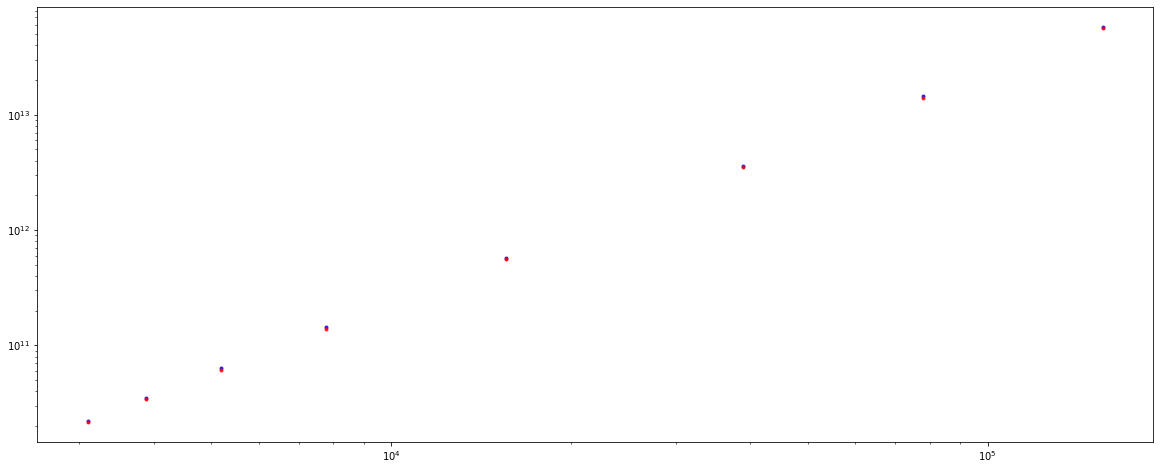

In [30]:
plt.figure(figsize=(20,8),facecolor=(1, 1, 1))

snr_vec = []
tru_vec = []
eva_vec = []
for i in range(len(datasets)):
    models[key][i].fix()
    evaluation = loss([],datasets[i],plt_epoch,models[key][i])
    models[key][i].fit(0)
    truth = loss(jabble.dataset.shifts(rvs),datasets[i],plt_epoch,models[key][i])

    snr = np.mean(all_data[i]['data']['snr_readout'][~np.isnan(all_data[i]['data']['snr_readout'])])
    
    print('snr: {:2.1e}\nfinal: {:2.3e}\ntruth: {:2.3e}'.format(snr,evaluation,truth))
#     plt.loglog(snr,truth,'b',alpha=0.8)
#     plt.loglog(snr,evaluation,'r',alpha=0.8)
    snr_vec.append(snr)
    tru_vec.append(truth)
    eva_vec.append(evaluation)
plt.loglog(snr_vec,tru_vec,'.b',alpha=0.8)
plt.loglog(snr_vec,eva_vec,'.r',alpha=0.8)
plt.show()

In [31]:
print(all_data[1]['parameters']['wavetransform']['m'])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
